In [1]:
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
  
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")



class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('CBIS-DDSM_classification','masks')
        self.bmask_dir = self.root_dir.replace('CBIS-DDSM_classification','breast_mask')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)

        label = self.data_frame.iloc[idx]['category']

        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_mask.j'))
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)
        
        bmask_name = os.path.join(self.bmask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_bmask.j'))
        bmask = io.imread(bmask_name)
        bmask = np.array([bmask,bmask,bmask]).transpose((1,2,0))
        bmask = Image.fromarray(bmask)
        

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) 
            bmask = self.transform(bmask)
    
        return {'image':image,'category':label,'mask':mask, 'bmask':bmask, 'name':img_name}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),#row to column ratio should be 1.69
            #transforms.RandomHorizontalFlip(0.5),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(translate=(0,0.2),degrees=15,shear=15),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device


def build_spd():
    
    class selector(nn.Module):
        def __init__(self,base):
            super().__init__()
            self.base = base
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(256,2)


        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x,x_base

    r18 = models.resnet18(pretrained=True)
    r = nn.Sequential(*list(r18.children())[:-3])
    #ir2 = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')
    #ir1 = nn.Sequential(*list(ir2.children())[:-6])
    model = selector(r)
        
    return model

def denorm_img(img_ten,img_mean,img_std):

    bz,nc,h,w = img_ten.shape
    output = []
    img_num = img_ten.numpy()
    
    for i in range(bz):
        
        img = img_ten[i].numpy().squeeze()
        
        img[0,:,:] = img[0,:,:]*img_std[0]
        img[1,:,:] = img[1,:,:]*img_std[1]
        img[2,:,:] = img[2,:,:]*img_std[2]

        img[0,:,:] = img[0,:,:] + img_mean[0]
        img[1,:,:] = img[1,:,:] + img_mean[1]
        img[2,:,:] = img[2,:,:] + img_mean[2]
        
        img = img.mean(axis=0)
        img[img>=0.5*img.max()] = 1
        img[img<0.5*img.max()] = 0
        
        output.append(img)
    
    output = np.array(output)
    return output
    
def get_IoU(pred, targs, device):

    pred[pred>pred.mean()+1*pred.std()] = 1
    pred[pred<pred.mean()+1*pred.std()] = 0

    targs = torch.Tensor(targs).to(device)
    
    #targs = torch.Tensor((targs>0)).to(device)#.float()
    #pred = (pred>0)#.float()
    return (pred*targs).sum() / ((pred+targs).sum() - (pred*targs).sum()),pred.sum()/(pred.shape[-1]*pred.shape[2])
    #return (pred*targs).sum()/targs.sum(),pred.sum()/(pred.shape[-1]*pred.shape[2])

def get_auc_roc(pred, targs):
    
    bz,c = pred.shape
    out = np.zeros(targs.shape)
    for i in range(bz):
        out[i] = pred[i][int(targs[i])]
    return roc_auc_score(targs,out)

def make_prob(a,device):
    b = a.shape[0]
    
    f1 = a.view(b,-1)
    mi = torch.min(f1,-1)
    
    t1 = torch.ones((b,1,1,1)).to(device)
    t1[:,0,0,0] = mi[0]
    
    d1 = a - t1
    
    ma = torch.max(d1.view(b,-1),-1)
    t2 = torch.ones((b,1,1,1)).to(device)
    t2[:,0,0,0] = ma[0]
    
    return d1/t2
      
def returnCAM(feature_conv, weight_softmax, class_idx, output_shape,device):
    
    size_upsample = output_shape
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for i in range(bz):
        #import pdb;pdb.set_trace()
        idx = class_idx[0][i]
        cam = weight_softmax[idx].dot(feature_conv[i].reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam_img = torch.Tensor(cv2.resize(cam,(size_upsample[0],size_upsample[1]))).to(device)
        cam_img[cam_img<0] = 0
        output_cam.append(cam_img)
    output_cam = torch.Tensor(output_cam).to(device)
    
    final_output_cam = torch.zeros((bz,1,size_upsample[1],size_upsample[0]))
    final_output_cam[:,0,:,:] = output_cam
    
    return final_output_cam

class dc_invase():
    def __init__(self, alpha=1, beta=0.1):
        
        #Initialization
        self.data_dir = '../Data/CBIS-DDSM_classification_orient/'
        self.train_csv = '../CSV/gain_train.csv'
        self.num_epochs = 30
        self.input_shape = (376,224) #(432,256) #(640,512) #(640,512)#(224,224)#(640,384) (640,512)
        self.batch_size = 1
        self.img_mean = [0.223, 0.231, 0.243]
        self.img_std = [0.266, 0.270, 0.274]

        self.alpha = 0.8
        self.beta = 0.5
        self.exp_name = 'dc_invase_res_cam_bm'
        
        #Define the three models
        self.selector = build_spd()
        self.predictor = build_spd()
        self.discriminator = build_spd()
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.predictor = self.predictor.cuda()
        self.discriminator = self.discriminator.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define the three optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_pred = optim.Adam(self.predictor.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_dis = optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        #self.optimizer_sel = optim.SGD(self.selector.parameters(),lr = 0.01, momentum=0.9)#lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        #self.optimizer_pred = optim.SGD(self.predictor.parameters(),lr = 0.01, momentum=0.9)#lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        #self.optimizer_dis = optim.SGD(self.discriminator.parameters(),lr = 0.01, momentum=0.9)#lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        self.l1_loss = nn.L1Loss()
        
    def train(self):
        
        since = time.time()
        best_epoch_sel_acc = 0.0
        best_iou = 0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    
                    #Set the models to training mode
                    self.predictor.train() 
                    self.discriminator.train()
                    self.selector.train()
                
                else:
                    #Set the models to evaluation mode
                    self.predictor.eval()
                    self.discriminator.eval()
                    self.selector.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_pred_loss = 0.0
                running_dis_loss = 0.0
                
                #Metrics : predictor auc and selector iou
                #running_pred_auc = 0
                running_iou = 0
                running_spa = 0
                running_sel_acc = 0
                running_pred_acc = 0
                running_dis_acc = 0

                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    mask = denorm_img(sampled_batch['mask'],self.img_mean,self.img_std)
                    bmask = torch.Tensor(denorm_img(sampled_batch['bmask'],self.img_mean,self.img_std)).to(self.device)

                    #mask = sampled_batch['mask']


                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)

                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_pred.zero_grad()
                    self.optimizer_dis.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                            
                        #Selector cnn predictions for the image
                        sel_out,feat = self.selector(inputs)
                                                
                        #convert sel_out to probabilities
                        sel_pred_prob = F.softmax(sel_out)
                        #Find the predictions
                        _, sel_preds = torch.max(sel_out, 1)

                        #Get the parameters list
                        params = list(self.selector.parameters())
                        
                        #Final layer weights
                        weight_softmax = torch.squeeze(params[-2].data)
                    
                        #Get the CAM which will the prob map
                        cam = torch.matmul(weight_softmax[sel_preds[0]],feat[0].view(feat[0].shape[0],-1))
                        cam = F.relu(cam.reshape(feat[0].shape[1], feat[0].shape[2]))
                        cam_img = F.interpolate(cam.unsqueeze(dim=0).unsqueeze(dim=0),(self.input_shape[0],self.input_shape[1]),mode='bilinear')
                        #cam_img = torch.Tensor(cv2.resize(cam.data.cpu().numpy(),(self.input_shape[1],self.input_shape[0]))).to(self.device)
                         
                        sel_prob = F.sigmoid(cam_img)
                        sel_prob = sel_prob*bmask
                        
                        #sel_prob = cam_img/cam_img.max()
                                                                        
                        #Compute the Complementary selection probability
                        comp_sel_prob = 1 - sel_prob
                        
                        #Generate X_S the selection probability masked image
                        x_s = inputs*sel_prob
                        
                        #Generate X_S_bar the complementary selection probability masked image
                        x_s_bar = inputs*comp_sel_prob
                        
                        #Generate predictor output probabilities
                        pred_out,_ = self.predictor(x_s)
                        pred_prob = F.softmax(pred_out)
                        _, pred_preds = torch.max(pred_out, 1)

                        
                        #Generate discriminator probabilities
                        dis_out,_ = self.discriminator(x_s_bar)
                        dis_prob = F.softmax(dis_out)
                        _, dis_preds = torch.max(dis_out, 1)

                        
                        #Predictor Cross entropy
                        pred_ce_loss = F.cross_entropy(pred_out,labels)
                        
                        #Discriminator Negative Cross entropy
                        dis_ce_loss = F.cross_entropy(dis_out,1-labels)
                        
                        #Selector function loss
                        sel_ce_loss = F.cross_entropy(sel_out,labels)
                        
                        #KL_1
                        kl_1 = pred_ce_loss - sel_ce_loss
                        
                        #LK_2
                        kl_2 = F.cross_entropy(dis_out,labels) - sel_ce_loss
                        
                        #L2 norm loss
                        #l2_norm = torch.norm(sel_prob.view((sel_prob.shape[0],-1)),2,-1)/torch.prod(torch.Tensor(self.input_shape).to(self.device))
                        #norm_loss = torch.mean(l2_norm)
                        
                        l1_loss = self.l1_loss(sel_prob,torch.zeros(sel_prob.shape,requires_grad=False).to(self.device))

                        
                        #Total selector loss
                        sel_loss = kl_1 - self.alpha*kl_2 + self.beta*l1_loss + sel_ce_loss
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            #Update predictor using pred_ce_loss
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            pred_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_pred.step()
                            
                            #The gradients of dis_ce_loss should not update the params of pred or sel
                            dis_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.step()
                            
                            #The gradients of sel_loss should not update the params of pred or dis
                            sel_loss.backward()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_sel.step()
                                    
                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                    running_dis_loss += dis_ce_loss.item() * inputs.size(0)

                    
                    #running_pred_auc += get_auc_roc(pred_prob.detach().cpu().numpy(),labels.data)
                    iou,spa = get_IoU(sel_prob,mask,self.device)
                    running_iou += iou
                    running_spa += spa
                    running_sel_acc += torch.sum(sel_preds == labels.data)
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_dis_acc += torch.sum(dis_preds == (1-labels.data))
                    
                    
                    pbar.update(inputs.shape[0])
                pbar.close()


                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                epoch_dis_loss = running_dis_loss / self.dataset_sizes[phase]
                
                #epoch_pred_auc = 1.0*running_pred_auc / self.dataset_sizes[phase]
                epoch_spa = running_spa.double()/ self.dataset_sizes[phase]
                epoch_IoU = running_iou.double() / self.dataset_sizes[phase]
                epoch_sel_acc = running_sel_acc.double() / self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_dis_acc = running_dis_acc.double() / self.dataset_sizes[phase]

                
                print('{} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} SAC: {:.4f} PAC: {:.4f} DAC: {:.4f} Spa: {:.4f} IoU: {:.4f}'.format(
                    phase, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_sel_acc, epoch_pred_acc, epoch_dis_acc, epoch_spa,  epoch_IoU))

                #print('{} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} ACC: {:.4f} AUC: {:.4f} IoU: {:.4f}'.format(
                #    phase, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_acc, epoch_pred_auc, epoch_IoU))

                # deep copy the model
                if phase == 'valid' and epoch_IoU > best_iou:
                    best_iou = epoch_IoU
                    #print(self.exp_name)
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.predictor.state_dict(),self.exp_name+'_pred.pt')
                    torch.save(self.discriminator.state_dict(),self.exp_name+'_dis.pt')


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best Sel Loss: {:4f}'.format(best_sel_loss))

        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')
        torch.save(self.predictor.state_dict(),self.exp_name+'_pred_final.pt')
        torch.save(self.discriminator.state_dict(),self.exp_name+'_dis_final.pt')

        print('Training completed finally !!!!!')
        
    def get_output(self,input_data):
        
        return self.selector(input_data).numpy()
        
    def test_model(self):
                
        self.selector.load_state_dict(self.exp_name+'_sel.pt')
        self.selector.eval()
        
        mIoU = 0
        total = 0
        mode = 'test'

        with torch.no_grad():
            for data in self.dataloaders[mode]:

                images = data['image']
                mask = data['mask']

                images = images.to(self.device)
                
                sel_prob = make_prob(self.selector(images))
                iou = get_IoU(sel_prob,mask)
                
                total += labels.size(0)
                mIoU += iou

        print("mIoU:", 1.0*mIoU/total)

    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['test']
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
  
#Pytorch
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#Torchvision
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader

#Image Processing
import matplotlib.pyplot as plt
from skimage import io, transform, color
import PIL
from PIL import Image

#Others
import sklearn.metrics
from sklearn.metrics import *
import numpy as np
import pandas as pd
import cv2
import time
import os
import copy
from model_summary import *
import pretrainedmodels
import tqdm
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")



class dataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):

        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_dir = self.root_dir.replace('CBIS-DDSM_classification','masks')
        self.bmask_dir = self.root_dir.replace('CBIS-DDSM_classification','breast_mask')
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.data_frame.iloc[idx]['name'])
        image = Image.open(img_name)

        label = self.data_frame.iloc[idx]['category']

        mask_name = os.path.join(self.mask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_mask.j'))
        mask = io.imread(mask_name)
        mask = np.array([mask,mask,mask]).transpose((1,2,0))
        mask = Image.fromarray(mask)
        
        bmask_name = os.path.join(self.bmask_dir,self.data_frame.iloc[idx]['name'].replace('.j','_bmask.j'))
        bmask = io.imread(bmask_name)
        bmask = np.array([bmask,bmask,bmask]).transpose((1,2,0))
        bmask = Image.fromarray(bmask)
        

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask) 
            bmask = self.transform(bmask)
    
        return {'image':image,'category':label,'mask':mask, 'bmask':bmask, 'name':img_name}
    

def get_dataloader(data_dir, train_csv_path, image_size, img_mean, img_std, batch_size=1):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(image_size),#row to column ratio should be 1.69
            #transforms.RandomHorizontalFlip(0.5),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.RandomVerticalFlip(0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(translate=(0,0.2),degrees=15,shear=15),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize(image_size),
            #transforms.CenterCrop((image_size[1],image_size[1])),
            transforms.ToTensor(),
            #transforms.Normalize([0.223, 0.231, 0.243], [0.266, 0.270, 0.274])
            transforms.Normalize(img_mean,img_std)
        ])
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}

    for x in ['train', 'valid', 'test']:
        image_datasets[x] = dataset(train_csv_path.replace('train',x),root_dir=data_dir,transform=data_transforms[x])
        dataloaders[x] = torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=8)    
        dataset_sizes[x] = len(image_datasets[x])

    device = torch.device("cuda:0")

    return dataloaders,dataset_sizes,image_datasets,device


def build_spd():
    
    class selector(nn.Module):
        def __init__(self,base):
            super().__init__()
            self.base = base
            self.gap = nn.AdaptiveAvgPool2d((1,1))
            self.fc = nn.Linear(256,2)


        def forward(self, x):
            x_base = self.base(x)
            x = self.gap(x_base)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x,x_base

    r18 = models.resnet18(pretrained=True)
    r = nn.Sequential(*list(r18.children())[:-3])
    #ir2 = pretrainedmodels.__dict__['inceptionresnetv2'](num_classes=1000, pretrained='imagenet')
    #ir1 = nn.Sequential(*list(ir2.children())[:-6])
    model = selector(r)
        
    return model

def denorm_img(img_ten,img_mean,img_std):

    bz,nc,h,w = img_ten.shape
    output = []
    img_num = img_ten.numpy()
    
    for i in range(bz):
        
        img = img_ten[i].numpy().squeeze()
        
        img[0,:,:] = img[0,:,:]*img_std[0]
        img[1,:,:] = img[1,:,:]*img_std[1]
        img[2,:,:] = img[2,:,:]*img_std[2]

        img[0,:,:] = img[0,:,:] + img_mean[0]
        img[1,:,:] = img[1,:,:] + img_mean[1]
        img[2,:,:] = img[2,:,:] + img_mean[2]
        
        img = img.mean(axis=0)
        img[img>=0.5*img.max()] = 1
        img[img<0.5*img.max()] = 0
        
        output.append(img)
    
    output = np.array(output)
    return output
    
def get_IoU(pred, targs, device):

    pred[pred>pred.mean()+1*pred.std()] = 1
    pred[pred<pred.mean()+1*pred.std()] = 0

    targs = torch.Tensor(targs).to(device)
    
    #targs = torch.Tensor((targs>0)).to(device)#.float()
    #pred = (pred>0)#.float()
    return (pred*targs).sum() / ((pred+targs).sum() - (pred*targs).sum()),pred.sum()/(pred.shape[-1]*pred.shape[2])
    #return (pred*targs).sum()/targs.sum(),pred.sum()/(pred.shape[-1]*pred.shape[2])

def get_auc_roc(pred, targs):
    
    bz,c = pred.shape
    out = np.zeros(targs.shape)
    for i in range(bz):
        out[i] = pred[i][int(targs[i])]
    return roc_auc_score(targs,out)

def make_prob(a,device):
    b = a.shape[0]
    
    f1 = a.view(b,-1)
    mi = torch.min(f1,-1)
    
    t1 = torch.ones((b,1,1,1)).to(device)
    t1[:,0,0,0] = mi[0]
    
    d1 = a - t1
    
    ma = torch.max(d1.view(b,-1),-1)
    t2 = torch.ones((b,1,1,1)).to(device)
    t2[:,0,0,0] = ma[0]
    
    return d1/t2
      
def returnCAM(feature_conv, weight_softmax, class_idx, output_shape,device):
    
    size_upsample = output_shape
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for i in range(bz):
        #import pdb;pdb.set_trace()
        idx = class_idx[0][i]
        cam = weight_softmax[idx].dot(feature_conv[i].reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam_img = torch.Tensor(cv2.resize(cam,(size_upsample[0],size_upsample[1]))).to(device)
        cam_img[cam_img<0] = 0
        output_cam.append(cam_img)
    output_cam = torch.Tensor(output_cam).to(device)
    
    final_output_cam = torch.zeros((bz,1,size_upsample[1],size_upsample[0]))
    final_output_cam[:,0,:,:] = output_cam
    
    return final_output_cam

class dc_invase():
    def __init__(self, alpha=1, beta=0.1):
        
        #Initialization
        self.data_dir = '../Data/CBIS-DDSM_classification_orient/'
        self.train_csv = '../CSV/gain_train.csv'
        self.num_epochs = 30
        self.input_shape = (376,224) #(432,256) #(640,512) #(640,512)#(224,224)#(640,384) (640,512)
        self.batch_size = 1
        self.img_mean = [0.223, 0.231, 0.243]
        self.img_std = [0.266, 0.270, 0.274]

        self.alpha = 0.8
        self.beta = 0.5
        self.exp_name = 'dc_invase_res_cam_bm'
        
        #Define the three models
        self.selector = build_spd()
        self.predictor = build_spd()
        self.discriminator = build_spd()
        
        #Put them on the GPU
        self.selector = self.selector.cuda()
        self.predictor = self.predictor.cuda()
        self.discriminator = self.discriminator.cuda()
        
        #Get the dataloaders
        self.dataloaders,self.dataset_sizes,self.dataset,self.device = get_dataloader(self.data_dir,self.train_csv,\
                                                        self.input_shape,self.img_mean,self.img_std,self.batch_size)
        
        #Define the three optimizers one for each model
        self.optimizer_sel = optim.Adam(self.selector.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_pred = optim.Adam(self.predictor.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.optimizer_dis = optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        #self.optimizer_sel = optim.SGD(self.selector.parameters(),lr = 0.01, momentum=0.9)#lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        #self.optimizer_pred = optim.SGD(self.predictor.parameters(),lr = 0.01, momentum=0.9)#lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        #self.optimizer_dis = optim.SGD(self.discriminator.parameters(),lr = 0.01, momentum=0.9)#lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        
        self.l1_loss = nn.L1Loss()
        
    def train(self):
        
        since = time.time()
        best_epoch_sel_acc = 0.0
        best_iou = 0

        for epoch in range(self.num_epochs):
            print('Epoch {}/{}'.format(epoch, self.num_epochs - 1),flush=True)
            print('-' * 10,flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    
                    #Set the models to training mode
                    self.predictor.train() 
                    self.discriminator.train()
                    self.selector.train()
                
                else:
                    #Set the models to evaluation mode
                    self.predictor.eval()
                    self.discriminator.eval()
                    self.selector.eval()
                    
                #Keep a track of all the three loss
                running_sel_loss = 0.0
                running_pred_loss = 0.0
                running_dis_loss = 0.0
                
                #Metrics : predictor auc and selector iou
                #running_pred_auc = 0
                running_iou = 0
                running_spa = 0
                running_sel_acc = 0
                running_pred_acc = 0
                running_dis_acc = 0

                #tqdm bar
                pbar = tqdm(total=self.dataset_sizes[phase])

                # Iterate over data.
                for sampled_batch in self.dataloaders[phase]:

                    inputs = sampled_batch['image']
                    labels = sampled_batch['category']
                    mask = denorm_img(sampled_batch['mask'],self.img_mean,self.img_std)
                    bmask = torch.Tensor(denorm_img(sampled_batch['bmask'],self.img_mean,self.img_std)).to(self.device)

                    #mask = sampled_batch['mask']


                    #Input needs to be float and labels long
                    inputs = inputs.float().to(self.device)
                    labels = labels.long().to(self.device)

                    # zero the parameter gradients
                    self.optimizer_sel.zero_grad()
                    self.optimizer_pred.zero_grad()
                    self.optimizer_dis.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        #import pdb;pdb.set_trace()
                            
                        #Selector cnn predictions for the image
                        sel_out,feat = self.selector(inputs)
                                                
                        #convert sel_out to probabilities
                        sel_pred_prob = F.softmax(sel_out)
                        #Find the predictions
                        _, sel_preds = torch.max(sel_out, 1)

                        #Get the parameters list
                        params = list(self.selector.parameters())
                        
                        #Final layer weights
                        weight_softmax = torch.squeeze(params[-2].data)
                    
                        #Get the CAM which will the prob map
                        cam = torch.matmul(weight_softmax[sel_preds[0]],feat[0].view(feat[0].shape[0],-1))
                        cam = F.relu(cam.reshape(feat[0].shape[1], feat[0].shape[2]))
                        cam_img = F.interpolate(cam.unsqueeze(dim=0).unsqueeze(dim=0),(self.input_shape[0],self.input_shape[1]),mode='bilinear')
                        #cam_img = torch.Tensor(cv2.resize(cam.data.cpu().numpy(),(self.input_shape[1],self.input_shape[0]))).to(self.device)
                         
                        sel_prob = F.sigmoid(cam_img)
                        sel_prob = sel_prob*bmask
                        
                        #sel_prob = cam_img/cam_img.max()
                                                                        
                        #Compute the Complementary selection probability
                        comp_sel_prob = 1 - sel_prob
                        
                        #Generate X_S the selection probability masked image
                        x_s = inputs*sel_prob
                        
                        #Generate X_S_bar the complementary selection probability masked image
                        x_s_bar = inputs*comp_sel_prob
                        
                        #Generate predictor output probabilities
                        pred_out,_ = self.predictor(x_s)
                        pred_prob = F.softmax(pred_out)
                        _, pred_preds = torch.max(pred_out, 1)

                        
                        #Generate discriminator probabilities
                        dis_out,_ = self.discriminator(x_s_bar)
                        dis_prob = F.softmax(dis_out)
                        _, dis_preds = torch.max(dis_out, 1)

                        
                        #Predictor Cross entropy
                        pred_ce_loss = F.cross_entropy(pred_out,labels)
                        
                        #Discriminator Negative Cross entropy
                        dis_ce_loss = F.cross_entropy(dis_out,1-labels)
                        
                        #Selector function loss
                        sel_ce_loss = F.cross_entropy(sel_out,labels)
                        
                        #KL_1
                        kl_1 = pred_ce_loss - sel_ce_loss
                        
                        #LK_2
                        kl_2 = F.cross_entropy(dis_out,labels) - sel_ce_loss
                        
                        #L2 norm loss
                        #l2_norm = torch.norm(sel_prob.view((sel_prob.shape[0],-1)),2,-1)/torch.prod(torch.Tensor(self.input_shape).to(self.device))
                        #norm_loss = torch.mean(l2_norm)
                        
                        l1_loss = self.l1_loss(sel_prob,torch.zeros(sel_prob.shape,requires_grad=False).to(self.device))

                        
                        #Total selector loss
                        sel_loss = kl_1 - self.alpha*kl_2 + self.beta*l1_loss + sel_ce_loss
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            
                            #Update predictor using pred_ce_loss
                            #The gradients of pred_ce_loss should not update the params of disc or sel
                            pred_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_pred.step()
                            
                            #The gradients of dis_ce_loss should not update the params of pred or sel
                            dis_ce_loss.backward(retain_graph=True)
                            self.optimizer_sel.zero_grad()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.step()
                            
                            #The gradients of sel_loss should not update the params of pred or dis
                            sel_loss.backward()
                            self.optimizer_pred.zero_grad()
                            self.optimizer_dis.zero_grad()
                            self.optimizer_sel.step()
                                    
                    # statistics
                    running_sel_loss += sel_loss.item() * inputs.size(0)
                    running_pred_loss += pred_ce_loss.item() * inputs.size(0)
                    running_dis_loss += dis_ce_loss.item() * inputs.size(0)

                    
                    #running_pred_auc += get_auc_roc(pred_prob.detach().cpu().numpy(),labels.data)
                    iou,spa = get_IoU(sel_prob,mask,self.device)
                    running_iou += iou
                    running_spa += spa
                    running_sel_acc += torch.sum(sel_preds == labels.data)
                    running_pred_acc += torch.sum(pred_preds == labels.data)
                    running_dis_acc += torch.sum(dis_preds == (1-labels.data))
                    
                    
                    pbar.update(inputs.shape[0])
                pbar.close()


                epoch_sel_loss = running_sel_loss / self.dataset_sizes[phase]
                epoch_pred_loss = running_pred_loss / self.dataset_sizes[phase]
                epoch_dis_loss = running_dis_loss / self.dataset_sizes[phase]
                
                #epoch_pred_auc = 1.0*running_pred_auc / self.dataset_sizes[phase]
                epoch_spa = running_spa.double()/ self.dataset_sizes[phase]
                epoch_IoU = running_iou.double() / self.dataset_sizes[phase]
                epoch_sel_acc = running_sel_acc.double() / self.dataset_sizes[phase]
                epoch_pred_acc = running_pred_acc.double() / self.dataset_sizes[phase]
                epoch_dis_acc = running_dis_acc.double() / self.dataset_sizes[phase]

                
                print('{} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} SAC: {:.4f} PAC: {:.4f} DAC: {:.4f} Spa: {:.4f} IoU: {:.4f}'.format(
                    phase, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_sel_acc, epoch_pred_acc, epoch_dis_acc, epoch_spa,  epoch_IoU))

                #print('{} Sel_Loss: {:.4f} Pred_Loss: {:.4f} Dis_Loss: {:.4f} ACC: {:.4f} AUC: {:.4f} IoU: {:.4f}'.format(
                #    phase, epoch_sel_loss, epoch_pred_loss, epoch_dis_loss, epoch_acc, epoch_pred_auc, epoch_IoU))

                # deep copy the model
                if phase == 'valid' and epoch_IoU > best_iou:
                    best_iou = epoch_IoU
                    #print(self.exp_name)
                    torch.save(self.selector.state_dict(),self.exp_name+'_sel.pt')
                    torch.save(self.predictor.state_dict(),self.exp_name+'_pred.pt')
                    torch.save(self.discriminator.state_dict(),self.exp_name+'_dis.pt')


        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best Sel Loss: {:4f}'.format(best_sel_loss))

        torch.save(self.selector.state_dict(),self.exp_name+'_sel_final.pt')
        torch.save(self.predictor.state_dict(),self.exp_name+'_pred_final.pt')
        torch.save(self.discriminator.state_dict(),self.exp_name+'_dis_final.pt')

        print('Training completed finally !!!!!')
        
    def get_output(self,input_data):
        
        return self.selector(input_data).numpy()
        
    def test_model(self):
                
        self.selector.load_state_dict(self.exp_name+'_sel.pt')
        self.selector.eval()
        
        mIoU = 0
        total = 0
        mode = 'test'

        with torch.no_grad():
            for data in self.dataloaders[mode]:

                images = data['image']
                mask = data['mask']

                images = images.to(self.device)
                
                sel_prob = make_prob(self.selector(images))
                iou = get_IoU(sel_prob,mask)
                
                total += labels.size(0)
                mIoU += iou

        print("mIoU:", 1.0*mIoU/total)

    def return_model(self):
        self.selector.load_state_dict(torch.load(self.exp_name+'_sel.pt'))
        self.selector.eval()
        return self.selector,self.dataloaders['test']


In [2]:
dci = dc_invase()

In [3]:
#dci.train()

## Testing the model on images

In [3]:
md,dl = dci.return_model()

In [4]:
a = iter(dl).next()

In [5]:
m = denorm_img(a['mask'],[0.223, 0.231, 0.243],[0.266, 0.270, 0.274])
bm = denorm_img(a['bmask'],[0.223, 0.231, 0.243],[0.266, 0.270, 0.274])

In [6]:
device = torch.device("cuda:0")

In [7]:
a['image'] = a['image']/a['image'].max()

In [8]:
p,feat = md(a['image'].to(device))

In [9]:
p = p.detach().cpu().numpy()
feat = feat.detach().cpu().numpy()

In [10]:
sel_preds = np.argmax(p)
params = list(md.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

In [11]:
#Get the CAM which will the prob map
cam = weight_softmax[sel_preds].dot(feat[0].reshape((feat[0].shape[0],np.prod(feat[0].shape[-2:]))))
cam =cam.reshape(feat[0].shape[1], feat[0].shape[2])
cam[cam<0] = 0

In [12]:
cam_img = cv2.resize(cam,(224,376))
                        #cam_img = transforms.Resize(self.input_shape)(cam)

In [13]:
cam_img[cam_img > cam_img.mean() + cam_img.std()] = 1
cam_img[cam_img < cam_img.mean() + cam_img.std()] = 0

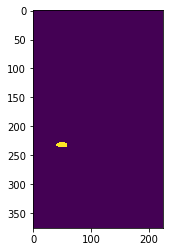

In [14]:
plt.imshow(m[0])

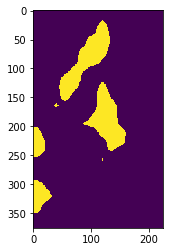

In [15]:
plt.imshow(cam_img*bm[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


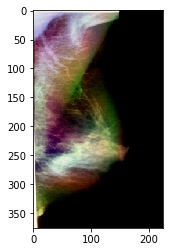

In [16]:
plt.imshow(a['image'].numpy().squeeze().transpose(1,2,0))

In [37]:
b = a['image'].numpy().squeeze().transpose(1,2,0)

In [38]:
c = b

In [142]:
a['name']

['../Data/CBIS-DDSM_classification_orient/Calc-Test_P_01272_LEFT_CC.jpg']